In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm

df = pd.read_csv('NEW.csv')
df.head()
df.columns

Index(['Dataset', 'Patient_name', '#', 'Surgery type on SX date',
       'MMCR (0), ELR (1)', 'Gender (Male = 1, Female = 2)', 'Age',
       'Eye (OD=0, OS=1)', 'Surgical eye (yes=1, no =0)',
       'Tissue Resected (mm)', 'Tarsus resected (Yes/No)',
       'Tarsus resected ( 0 for no tarsus, # for mm of tarsus removed)',
       'Length of follow up (mo)', 'Preop_MRD1', 'Most recent Post Op MRD1',
       'Change in MRD (post-pre)', 'Unilateral', '1 eye tarsus+ 1 eye normal',
       'Both eyes tarsus', 'Other surgeries at the same time', 'OD/OS',
       'Sx Date'],
      dtype='object')

In [2]:
df.groupby('Tarsus resected (Yes/No)')['Preop_MRD1'].mean()

Tarsus resected (Yes/No)
0    1.133333
N    1.572238
Y    0.469154
Name: Preop_MRD1, dtype: float64

Labeling

In [3]:
df['Tarsus_resected'] = df['Tarsus resected (Yes/No)'].map({'Y': 1, 'N': 0})
df['Other_surgeries_factor'] = df['Other surgeries at the same time'].astype('category')

Group by Tarsectomy

In [4]:
df[['Tarsus_resected', 'Change in MRD (post-pre)']].groupby('Tarsus_resected').describe()

Change in MRD (post-pre)                                      \
                                   count      mean       std    min      25%   
Tarsus_resected                                                                
0.0                                130.0  1.264223  1.149764 -1.490  0.48525   
1.0                                 26.0  2.411577  1.307257  0.496  1.36000   

                                       
                   50%     75%    max  
Tarsus_resected                        
0.0              1.205  2.0215  3.979  
1.0              2.435  3.2185  5.190

Simple t-test

In [5]:
group1 = df[df['Tarsus_resected'] == 1]['Change in MRD (post-pre)']
group0 = df[df['Tarsus_resected'] == 0]['Change in MRD (post-pre)']
t_stat, p_val = ttest_ind(group1.dropna(), group0.dropna(), equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

T-statistic: 4.165, p-value: 0.000


OLS

In [6]:
ols_model = smf.ols('Q("Change in MRD (post-pre)") ~ Tarsus_resected', data=df).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Q("Change in MRD (post-pre)")   R-squared:                       0.118
Model:                                       OLS   Adj. R-squared:                  0.112
Method:                            Least Squares   F-statistic:                     20.60
Date:                           Wed, 28 May 2025   Prob (F-statistic):           1.14e-05
Time:                                   19:06:51   Log-Likelihood:                -245.74
No. Observations:                            156   AIC:                             495.5
Df Residuals:                                154   BIC:                             501.6
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.2642      0.103     12.249      0.000       1.060       1.468
Tarsus_resected     1.1474      0.253      4.538      0.000       0.648       1.647
==============================================================================
Omnibus:                        0.950   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.622   Jarque-Bera (JB):                1.048
Skew:                           0.128   Prob(JB):                        0.592
Kurtosis:                       2.691   Cond. No.                         2.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Visualizations

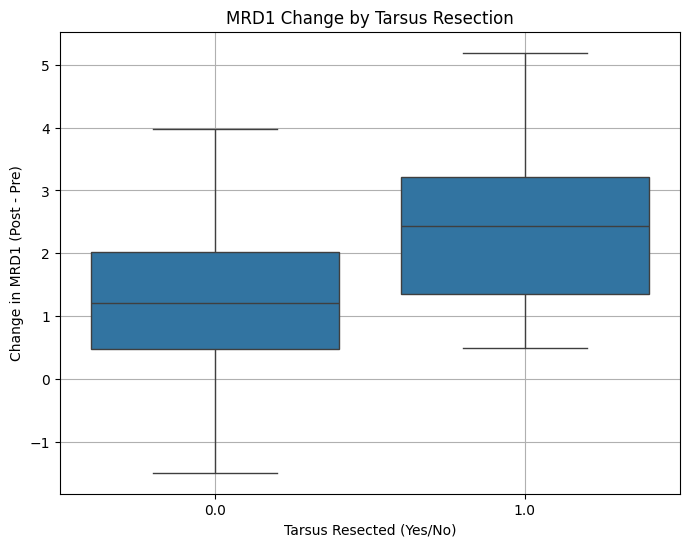

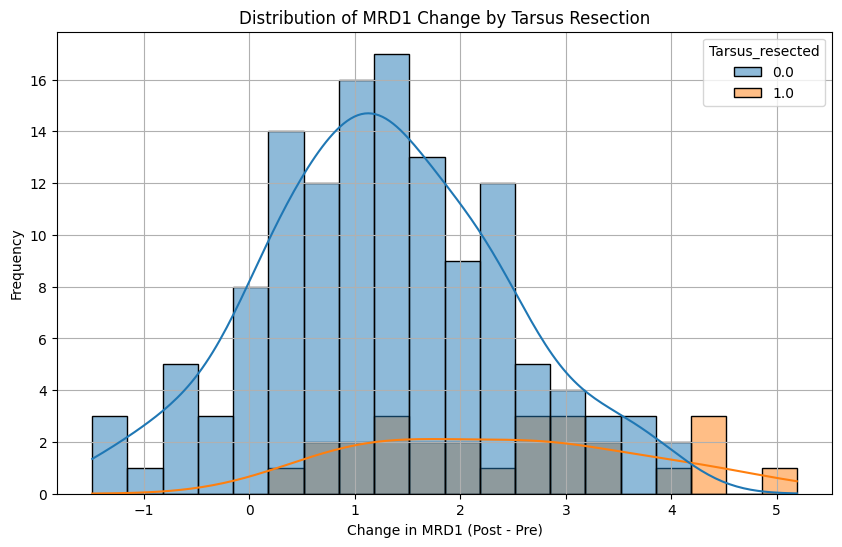

In [7]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Tarsus_resected', y='Change in MRD (post-pre)', data=df)
plt.title('MRD1 Change by Tarsus Resection')
plt.xlabel('Tarsus Resected (Yes/No)')
plt.ylabel('Change in MRD1 (Post - Pre)')
plt.grid(True)
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Change in MRD (post-pre)', hue='Tarsus_resected', bins=20, kde=True, alpha=0.5)
plt.title('Distribution of MRD1 Change by Tarsus Resection')
plt.xlabel('Change in MRD1 (Post - Pre)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Introduce Pre-op MRD1 as a predictor to control for its effects
ANCOVA

In [8]:
df = df.dropna(subset=['Preop_MRD1', 'Most recent Post Op MRD1', 'Tarsus_resected'])

model = smf.ols(
    'Q("Most recent Post Op MRD1") ~ Q("Preop_MRD1") * Tarsus_resected',
    data=df
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Q("Most recent Post Op MRD1")   R-squared:                       0.218
Model:                                       OLS   Adj. R-squared:                  0.202
Method:                            Least Squares   F-statistic:                     14.12
Date:                           Wed, 28 May 2025   Prob (F-statistic):           3.63e-08
Time:                                   19:06:51   Log-Likelihood:                -220.54
No. Observations:                            156   AIC:                             449.1
Df Residuals:                                152   BIC:                             461.3
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           2.0867      0.159     13.120      0.000       1.772       2.401
Q("Preop_MRD1")                     0.4769      0.084      5.671      0.000       0.311       0.643
Tarsus_resected                     0.5967      0.261      2.285      0.024       0.081       1.113
Q("Preop_MRD1"):Tarsus_resected    -0.0563      0.156     -0.360      0.720      -0.365       0.253
==============================================================================
Omnibus:                        3.367   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.186   Jarque-Bera (JB):                3.026
Skew:                           0.337   Prob(JB):                        0.220
Kurtosis:                       3.112   Cond. No.                         7.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 800x600 with 0 Axes>

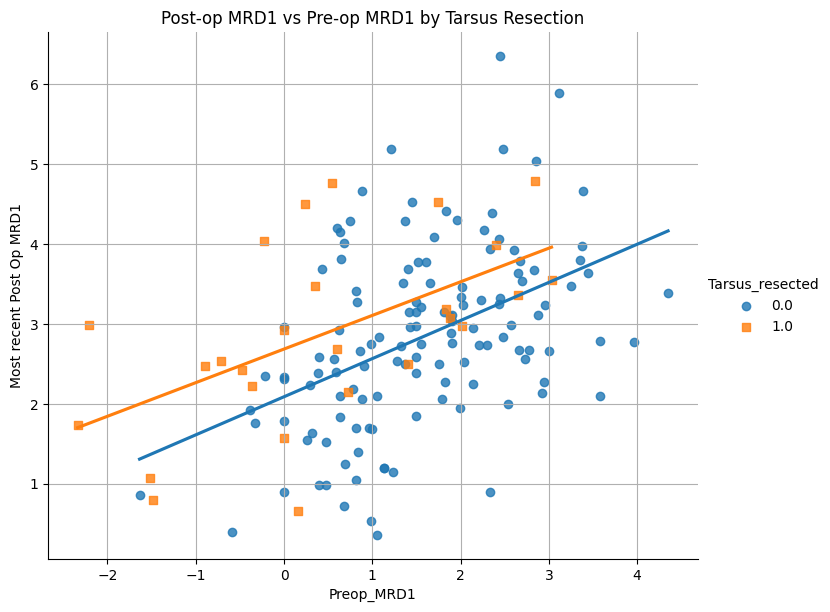

In [9]:
# Plot pre-op vs post-op MRD1 with separate regression lines by tarsus group
plt.figure(figsize=(8, 6))
sns.lmplot(
    data=df,
    x='Preop_MRD1', 
    y='Most recent Post Op MRD1', 
    hue='Tarsus_resected', 
    height=6, 
    aspect=1.2,
    markers=['o', 's'],
    ci = None
)
plt.title('Post-op MRD1 vs Pre-op MRD1 by Tarsus Resection')
plt.grid(True)
plt.show()

In [10]:
model = smf.ols(
    'Q("Most recent Post Op MRD1") ~ Q("Preop_MRD1") + Tarsus_resected',
    data=df
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Q("Most recent Post Op MRD1")   R-squared:                       0.217
Model:                                       OLS   Adj. R-squared:                  0.207
Method:                            Least Squares   F-statistic:                     21.23
Date:                           Wed, 28 May 2025   Prob (F-statistic):           7.27e-09
Time:                                   19:06:52   Log-Likelihood:                -220.61
No. Observations:                            156   AIC:                             447.2
Df Residuals:                                153   BIC:                             456.4
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1122      0.142     14.887      0.000       1.832       2.393
Q("Preop_MRD1")     0.4606      0.071      6.514      0.000       0.321       0.600
Tarsus_resected     0.5524      0.230      2.406      0.017       0.099       1.006
==============================================================================
Omnibus:                        3.487   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                3.143
Skew:                           0.343   Prob(JB):                        0.208
Kurtosis:                       3.116   Cond. No.                         6.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/k9/972x7z8s0zz_56m_1xxv33s00000gn/T/ipykernel_87161/1610874509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'resid_postop'] = model.resid  # residuals = what’s not explained by the model


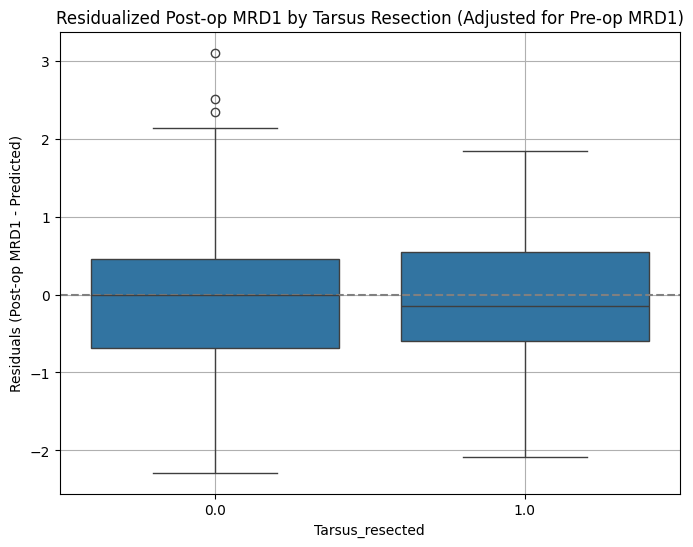

In [11]:
# Create adjusted values: remove influence of pre-op MRD1
df.loc[:, 'resid_postop'] = model.resid  # residuals = what’s not explained by the model

# Plot adjusted MRD1 by group
plt.figure(figsize=(8, 6))
sns.boxplot(x='Tarsus_resected', y='resid_postop', data=df)
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residualized Post-op MRD1 by Tarsus Resection (Adjusted for Pre-op MRD1)')
plt.ylabel('Residuals (Post-op MRD1 - Predicted)')
plt.grid(True)
plt.show()

In [12]:
resid_yes = df[df['Tarsus_resected'] == 1]['resid_postop']
resid_no = df[df['Tarsus_resected'] == 0]['resid_postop']

t_stat, p_val = ttest_ind(resid_yes, resid_no, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

T-statistic: 0.000, p-value: 1.000


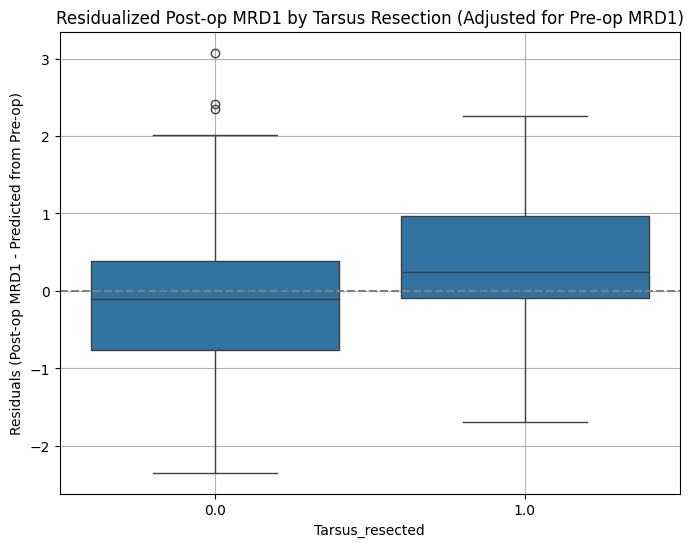

T-statistic: 2.342, p-value: 0.025


In [13]:
# Step 1: Fit model with only Pre-op MRD1
model_preop_only = smf.ols(
    'Q("Most recent Post Op MRD1") ~ Q("Preop_MRD1")',
    data=df
).fit()

# Step 2: Get residuals = adjusted post-op values (remove pre-op influence)
df.loc[:, 'resid_postop'] = model_preop_only.resid

# Step 3: Plot residuals by Tarsus group
plt.figure(figsize=(8, 6))
sns.boxplot(x='Tarsus_resected', y='resid_postop', data=df)
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residualized Post-op MRD1 by Tarsus Resection (Adjusted for Pre-op MRD1)')
plt.ylabel('Residuals (Post-op MRD1 - Predicted from Pre-op)')
plt.grid(True)
plt.show()

# Step 4: Statistically test for difference
from scipy.stats import ttest_ind

group1 = df[df['Tarsus_resected'] == 1]['resid_postop'].dropna()
group0 = df[df['Tarsus_resected'] == 0]['resid_postop'].dropna()
t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")


/var/folders/k9/972x7z8s0zz_56m_1xxv33s00000gn/T/ipykernel_87161/1361886558.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fitted_change'] = model.fittedvalues
/var/folders/k9/972x7z8s0zz_56m_1xxv33s00000gn/T/ipykernel_87161/1361886558.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tarsus_group'] = df['Tarsus_resected'].map({1: 'Tarsectomy', 0: 'No Tarsectomy'})


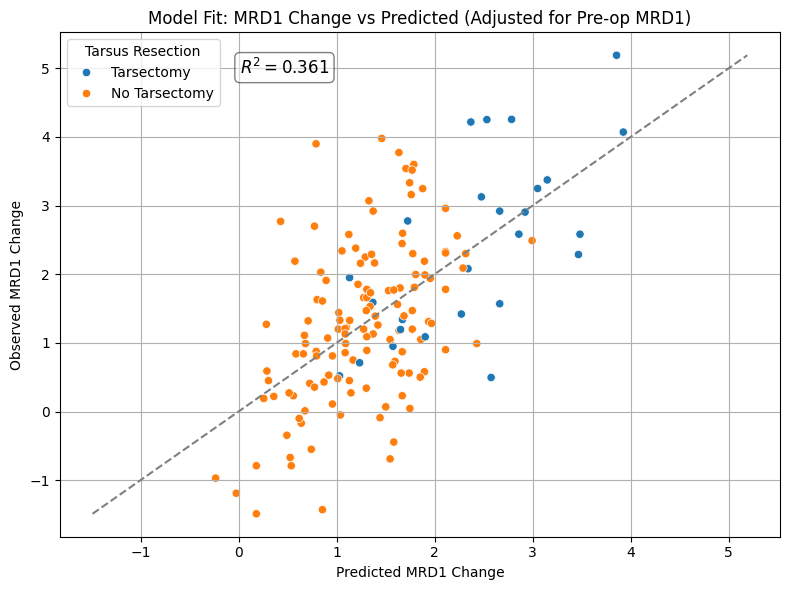

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

# Fit the model using the correct column name
model = smf.ols(
    'Q("Change in MRD (post-pre)") ~ Q("Preop_MRD1") + Tarsus_resected',
    data=df
).fit()

# Add predicted values to the DataFrame
df['fitted_change'] = model.fittedvalues
df['Tarsus_group'] = df['Tarsus_resected'].map({1: 'Tarsectomy', 0: 'No Tarsectomy'})

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='fitted_change', y='Change in MRD (post-pre)', hue='Tarsus_group', data=df)

# Add 1:1 reference line
min_val = min(df['fitted_change'].min(), df['Change in MRD (post-pre)'].min())
max_val = max(df['fitted_change'].max(), df['Change in MRD (post-pre)'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')

# Annotate R^2
r_squared = model.rsquared
plt.text(0.25, 0.95, f'$R^2 = {r_squared:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Plot labels and layout
plt.xlabel('Predicted MRD1 Change')
plt.ylabel('Observed MRD1 Change')
plt.title('Model Fit: MRD1 Change vs Predicted (Adjusted for Pre-op MRD1)')
plt.grid(True)
plt.legend(title='Tarsus Resection')
plt.tight_layout()
plt.show()
